### <center>  Лабораторна робота №6. Ідентифікація користувача за допомогою логістичної регресії</center>

In [6]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

### 1. Завантаження і перетворення даних

In [7]:
# завантажимо навчальну і тестову вибірки
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv(' ',
                      index_col='session_id')

In [8]:
# приведемо колонку time1, ..., time10 до часового формату
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)


In [9]:
# відсортуємо дані за часом
train_df = train_df.sort_values(by='time1')

# подивимося на заголовок навчальної вибірки
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [10]:
# приведемо колонки site1, ..., site10 до цілочислового формату і замінимо пропуски нулями
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

train_df


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,2014-04-30 23:33:48,50,2014-04-30 23:33:49,48,2014-04-30 23:33:52,49,2014-04-30 23:33:52,48,2014-04-30 23:33:53,...,2014-04-30 23:33:53,52,2014-04-30 23:33:54,49,2014-04-30 23:33:54,303,2014-04-30 23:33:57,304,2014-04-30 23:34:00,0
164438,4207,2014-04-30 23:34:15,753,2014-04-30 23:34:16,753,2014-04-30 23:34:17,52,2014-04-30 23:34:18,50,2014-04-30 23:34:18,...,2014-04-30 23:35:16,3346,2014-04-30 23:35:29,3359,2014-04-30 23:36:12,3346,2014-04-30 23:36:42,38,2014-04-30 23:37:13,0
12221,52,2014-04-30 23:38:08,3346,2014-04-30 23:38:10,784,2014-04-30 23:38:13,784,2014-04-30 23:38:18,3346,2014-04-30 23:38:22,...,2014-04-30 23:38:24,3324,2014-04-30 23:38:35,7330,2014-04-30 23:38:35,3594,2014-04-30 23:38:35,3329,2014-04-30 23:38:36,0


In [11]:
# завантажимо словник сайтів
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)


In [12]:
# датафрейм словника сайтів
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])
print(u'всього сайтів:', sites_dict_df.shape[0])
sites_dict_df.head()

всього сайтів: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


### Виділимо цільову змінну і об'єднаємо вибірки, щоб разом привести їх до розрідженого формату.

In [13]:
# наша цільова змінна
y_train = train_df['target']

# об'єднана таблиця вхідних даних
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# індекс, за яким будемо відокремлювати навчальну вибірку від тестової
idx_split = train_df.shape[0]

print(train_df)

            site1               time1  site2               time2  site3  \
session_id                                                                
21669          56 2013-01-12 08:05:57     55 2013-01-12 08:05:57      0   
54843          56 2013-01-12 08:37:23     55 2013-01-12 08:37:23     56   
77292         946 2013-01-12 08:50:13    946 2013-01-12 08:50:14    951   
114021        945 2013-01-12 08:50:17    948 2013-01-12 08:50:17    949   
146670        947 2013-01-12 08:50:20    950 2013-01-12 08:50:20    948   
...           ...                 ...    ...                 ...    ...   
12224          50 2014-04-30 23:33:48     50 2014-04-30 23:33:49     48   
164438       4207 2014-04-30 23:34:15    753 2014-04-30 23:34:16    753   
12221          52 2014-04-30 23:38:08   3346 2014-04-30 23:38:10    784   
156968       3328 2014-04-30 23:38:36   3324 2014-04-30 23:38:36   3599   
204762        222 2014-04-30 23:39:53   3346 2014-04-30 23:39:59   3346   

                        

Підготуємо дані, з усієї таблиці виберемо лише ознаки site1, site2, ..., site10. Нагадуємо, що пропущені значення замінені нулем. Ось як виглядатимуть перші рядки таблиць:



In [14]:
# таблиця з індексами відвіданих сайтів в сесії
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [15]:
from scipy.sparse import csr_matrix

In [16]:
csr_matrix

scipy.sparse._csr.csr_matrix

In [17]:
# послідовність з індексами (розплющенна)
sites_flatten = full_sites.values.flatten()

# розріджена матриця
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

print(full_sites_sparse[:idx_split])



  (0, 55)	1
  (0, 54)	1
  (1, 55)	1
  (1, 54)	1
  (1, 55)	1
  (1, 54)	1
  (2, 945)	1
  (2, 945)	1
  (2, 950)	1
  (2, 945)	1
  (2, 945)	1
  (2, 944)	1
  (2, 947)	1
  (2, 783)	1
  (2, 948)	1
  (2, 945)	1
  (3, 944)	1
  (3, 947)	1
  (3, 948)	1
  (3, 947)	1
  (3, 944)	1
  (3, 945)	1
  (3, 946)	1
  (3, 944)	1
  (3, 945)	1
  :	:
  (253558, 783)	1
  (253558, 783)	1
  (253558, 3345)	1
  (253558, 978)	1
  (253558, 3323)	1
  (253558, 7329)	1
  (253558, 3593)	1
  (253558, 3328)	1
  (253559, 3327)	1
  (253559, 3323)	1
  (253559, 3598)	1
  (253559, 3412)	1
  (253559, 752)	1
  (253559, 3327)	1
  (253559, 3598)	1
  (253559, 3358)	1
  (253559, 3358)	1
  (253559, 3345)	1
  (253560, 221)	1
  (253560, 3345)	1
  (253560, 3345)	1
  (253560, 3358)	1
  (253560, 54)	1
  (253560, 2890)	1
  (253560, 3345)	1


### 2. Побудова першої моделі

Напишіть просту функцію, яка поверне якість моделей на вкладеній вибірці, і навчіть наш перший класифікатор.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def get_auc_lr_valid(X, y, C=1.0, ratio=0.9, seed=17):
    # Розділbnb дані на навчальну та валідаційну вибірку
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=ratio, shuffle=False, random_state=seed)
    
    # Створення та навчання модель логістичної регресії
    lr = LogisticRegression(C=C, random_state=seed, max_iter=1000)
    lr.fit(X_train, y_train)
    
    # Зробити прогноз для валідаційної вибірки
    y_pred = lr.predict_proba(X_valid)[:, 1]
    
    # Розраховуємо AUC
    auc = roc_auc_score(y_valid, y_pred)
    
    return auc

Подивіться, який отримано ROC AUC на відкладеній вибірці.

In [19]:
X = full_sites_sparse[:idx_split]
y = y_train
roc_auc = get_auc_lr_valid(X, y)
print("AUC-ROC для логістичної регресії:", roc_auc)

AUC-ROC для логістичної регресії: 0.9190592058149744


In [20]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Навчіть модель на всій вибірці, зробіть прогноз для тестової вибірки і покажіть результат.

In [22]:
# Завантаження тестових даних (замість X_test, ви повинні вказати свої дані)
X_train = full_sites_sparse[:idx_split]
# Отримання тестового набору даних
test_df = full_df[idx_split:]

# Створення розрідженої матриці для тестової вибірки
sites_flatten_test = test_df[sites].values.flatten()

X_test = csr_matrix(([1] * sites_flatten_test.shape[0],
                     sites_flatten_test,
                     range(0, sites_flatten_test.shape[0] + 10, 10)))[:, 1:]


# Навчання моделі логістичної регресії на всій навчальній вибірці
lr = LogisticRegression(C=1.0, random_state=17, max_iter=1000)
lr.fit(X_train, y_train)

# Зроблення прогнозів для тестових даних
y_pred_test = lr.predict_proba(X_test)[:, 1]

# Запис прогнозів у файл
write_to_submission_file(y_pred_test, "submission.csv")

c:\Users\Богдан\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Богдан\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


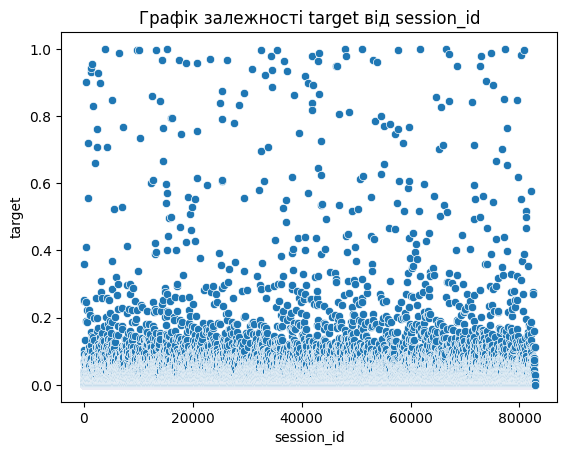

In [40]:
# Створення графіку

import seaborn as sns
import matplotlib.pyplot as plt

# Дані
data = pd.read_csv('submission.csv')

# Побудова графіку
sns.scatterplot(x='session_id', y='target', data=data)

# Налаштування заголовка і осей
plt.title('Графік залежності target від session_id')
plt.xlabel('session_id')
plt.ylabel('target')

# Відображення графіку
plt.show()








### 3. Покращення моделі, побудова нових ознак

Створіть таку ознаку, яка буде представлят собою число формату ГГГГММ від тої дати, коли відбувалась сесія, наприклад 201407 -- 2014 рік і 7 месяц. Таким чином, ми будемо враховувати помісячний [линейный тренд](http://people.duke.edu/~rnau/411trend.htm) за весь період наданих даних.

In [26]:
# Виділення окремої колонки з датами сесій
dates = full_df['time1']

# Створення нової колонки з ріком і місяцем у форматі ГГГГММ
full_df['year_month'] = dates.dt.strftime('%Y%m')

# Виведення перших рядків DataFrame з новою ознакою
full_df.head(10)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,year_month
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,201301
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,201301
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,201301
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,201301
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,201301
242171,952,2013-01-12 08:50:22,947,2013-01-12 08:50:23,953,2013-01-12 08:50:23,946,2013-01-12 08:50:23,947,2013-01-12 08:50:24,...,2013-01-12 08:50:24,953,2013-01-12 08:50:24,955,2013-01-12 08:50:24,946,2013-01-12 08:50:25,947,2013-01-12 08:50:25,201301
57157,953,2013-01-12 08:50:25,947,2013-01-12 08:50:26,946,2013-01-12 08:50:26,953,2013-01-12 08:50:26,955,2013-01-12 08:50:26,...,2013-01-12 08:50:27,953,2013-01-12 08:50:27,946,2013-01-12 08:50:27,953,2013-01-12 08:50:28,1033,2013-01-12 08:50:28,201301
240201,946,2013-01-12 08:50:28,947,2013-01-12 08:50:28,954,2013-01-12 08:50:28,953,2013-01-12 08:50:29,946,2013-01-12 08:50:29,...,2013-01-12 08:50:29,946,2013-01-12 08:50:30,956,2013-01-12 08:50:30,957,2013-01-12 08:50:31,956,2013-01-12 08:50:31,201301
210686,946,2013-01-12 08:50:31,956,2013-01-12 08:50:32,946,2013-01-12 08:50:32,946,2013-01-12 08:50:33,955,2013-01-12 08:50:33,...,2013-01-12 08:50:33,946,2013-01-12 08:50:34,946,2013-01-12 08:50:35,946,2013-01-12 08:50:36,948,2013-01-12 08:50:36,201301


In [27]:
# Створення нової ознаки на основі річного та місячного формату дати
full_df['year_month'] = dates.dt.strftime('%Y%m')

# Отримання навчальної та валідаційної вибірок для нової ознаки
X = full_df['year_month'][:idx_split].values.reshape(-1, 1)
X_valid = full_df['year_month'][idx_split:].values.reshape(-1, 1)

# Ініціалізація та нормалізація нової ознаки за допомогою StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_valid_scaled = scaler.transform(X_valid)

# Підрахунок ROC AUC на відкладеній вибірці
roc_auc = get_auc_lr_valid(X_scaled, y_train)
print("AUC-ROC для нормалізованої ознаки:", roc_auc)

AUC-ROC для нормалізованої ознаки: 0.5


In [28]:
# Створення ознаки start_hour (година початку сесії)
full_df['start_hour'] = dates.dt.hour

# Створення бінарної ознаки morning (ранок)
full_df['morning'] = (full_df['start_hour'] <= 11).astype(int)

In [30]:
from scipy.sparse import hstack

# Створення ознаки start_month
full_df['start_month'] = dates.dt.strftime('%Y%m')

# Отримання навчальної та валідаційної вибірок для нових ознак
X_sites = full_sites_sparse[:idx_split]
X_valid_sites = full_sites_sparse[idx_split:]
X_start_month = full_df['start_month'][:idx_split].values.reshape(-1, 1)
X_valid_start_month = full_df['start_month'][idx_split:].values.reshape(-1, 1)
X_start_hour = full_df['start_hour'][:idx_split].values.reshape(-1, 1)
X_valid_start_hour = full_df['start_hour'][idx_split:].values.reshape(-1, 1)
X_morning = full_df['morning'][:idx_split].values.reshape(-1, 1)
X_valid_morning = full_df['morning'][idx_split:].values.reshape(-1, 1)

# Ототжнювання усіх типів даних в float64
X_sites = X_sites.astype('float64')
X_start_month = X_start_month.astype('float64')
X_start_hour = X_start_hour.astype('float64')
X_morning = X_morning.astype('float64')

X_valid_sites = X_valid_sites.astype('float64')
X_valid_start_month = X_valid_start_month.astype('float64')
X_valid_start_hour = X_valid_start_hour.astype('float64')
X_valid_morning = X_valid_morning.astype('float64')

# Об'єднання ознак за допомогою hstack
X_combined1 = hstack([X_sites, X_start_month, X_start_hour])
X_valid_combined1 = hstack([X_valid_sites, X_valid_start_month, X_valid_start_hour])

X_combined2 = hstack([X_sites, X_start_month, X_morning])
X_valid_combined2 = hstack([X_valid_sites, X_valid_start_month, X_valid_morning])

X_combined3 = hstack([X_sites, X_start_month, X_start_hour, X_morning])
X_valid_combined3 = hstack([X_valid_sites, X_valid_start_month, X_valid_start_hour, X_valid_morning])

# Підрахунок ROC AUC для різних комбінацій ознак
roc_auc1 = get_auc_lr_valid(X_combined1, y_train)
roc_auc2 = get_auc_lr_valid(X_combined2, y_train)
roc_auc3 = get_auc_lr_valid(X_combined3, y_train)

print("ROC AUC для сайтів, start_month і start_hour:", roc_auc1)
print("ROC AUC для сайтів, start_month і morning:", roc_auc2)
print("ROC AUC для сайтів, start_month, start_hour і morning:", roc_auc3)

ROC AUC для сайтів, start_month і start_hour: 0.9195430875929421
ROC AUC для сайтів, start_month і morning: 0.881889145107473
ROC AUC для сайтів, start_month, start_hour і morning: 0.9195498050283248


### 4. Підбір коефіцієнта регуляризації

Порахуйте якість на відкладеній вибірці з коефіцієнтом регуляризації, який за замовчуванням `C = 1 ':

In [31]:
from sklearn.model_selection import cross_val_score

# Створення діапазону значень C для крос-валідації
C_values = [0.001, 0.01, 0.1, 1, 10]

# Створення порожнього словника для збереження середніх значень метрик для кожного значення C
mean_auc_scores = {}

for C in C_values:
    # Створення моделі логістичної регресії з поточним значенням C
    lr = LogisticRegression(C=C, random_state=17, max_iter=1000)
    
    # Виконання K-кратної крос-валідації та збереження результатів
    auc_scores = cross_val_score(lr, X_combined3, y_train, cv=5, scoring='roc_auc')
    
    # Збереження середнього значення ROC AUC для поточного значення C
    mean_auc_scores[C] = auc_scores.mean()

# Знаходження значення C, яке дає найкращий результат
best_C = max(mean_auc_scores, key=mean_auc_scores.get)
best_auc = mean_auc_scores[best_C]

print(f"Найкраще значення C: {best_C}")
print(f"Середнє значення ROC AUC для найкращого C: {best_auc}")

Найкраще значення C: 0.001
Середнє значення ROC AUC для найкращого C: 0.8013281320559091


Знайдіть C зnp.logspace (-3, 1, 10), при якому ROC AUC на відкладеної вибірці максимальний.

In [32]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Задання діапазону значень C для перебору
C_range = np.logspace(-3, 1, 10)

# Створення порожнього словника для збереження результатів
roc_auc_scores = {}

for C in C_range:
    # Створення моделі логістичної регресії з поточним значенням C
    lr = LogisticRegression(C=C, random_state=17, max_iter=1000)
    
    # Виконання K-кратної крос-валідації та збереження результатів
    auc_scores = cross_val_score(lr, X_combined3, y_train, cv=5, scoring='roc_auc')
    
    # Збереження середнього значення ROC AUC для поточного значення C
    roc_auc_scores[C] = auc_scores.mean()

# Знаходження C, яке дає максимальний ROC AUC
best_C = max(roc_auc_scores, key=roc_auc_scores.get)
best_auc = roc_auc_scores[best_C]

print(f"Найкраще значення C: {best_C}")
print(f"ROC AUC для найкращого C: {best_auc}")

Найкраще значення C: 0.0027825594022071257
ROC AUC для найкращого C: 0.8013281363912708


навчіть модель зі знайденим оптимальним значенням коефіцієнта регуляризації і з побудованими ознаками start_hour,start_month і morning.

In [33]:
# Виберати знайдене оптимальне значення C
best_C = 0.0027825594022071257

# Створення моделі логістичної регресії з оптимальним C
lr = LogisticRegression(C=best_C, random_state=17, max_iter=1000)

# Навчання моделі на повному наборі даних
lr.fit(X_combined3, y_train)

LogisticRegression(C=0.0027825594022071257, max_iter=1000, random_state=17)